<a href="https://colab.research.google.com/github/AdamChomicki/CNN/blob/main/CNN_project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D
from mpl_toolkits.axes_grid1 import ImageGrid

from tensorflow import keras

In [13]:
base_dir = "/content/drive/MyDrive/Uczenie maszynowe/Projekty/Praca dyplomowa - mgr/img"

In [14]:
input_shape = (160,160,3)

### Data ingestion

In [15]:
def read_images(dir:str, input_shape:tuple):
  return np.array([cv2.resize(cv2.imread(os.path.join(dir, path)), input_shape[0:2]) for path in os.listdir(dir)])

df = read_images(os.path.join(base_dir), input_shape)
df.shape

(100, 160, 160, 3)

### Data divide

In [16]:
X_train, X_valid, X_test = np.split(df, [int(0.6*len(df)),int(0.8*len(df))])

In [17]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(60, 160, 160, 3)
(20, 160, 160, 3)
(20, 160, 160, 3)


### Viewing photos

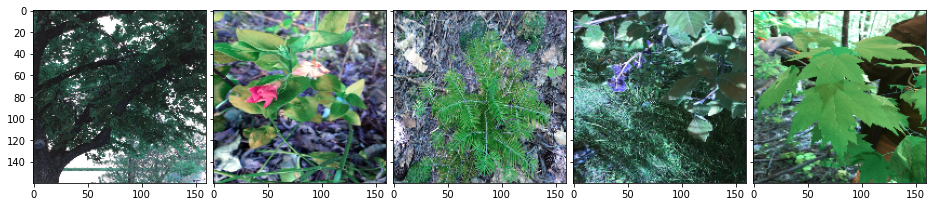

In [18]:
images = X_train[:5]

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1,5),
                 axes_pad=0.1
                 )

for ax, image in zip(grid, images):
  ax.imshow(image)

plt.show()

### Model

In [19]:
class createAugment(keras.utils.Sequence):

    def __init__(self, X, y, batch_size=32, dim=(160, 160), n_channels=3, shuffle=True):
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.on_epoch_end()

    def __len__(self):
        'Oznacza liczbę batchy na epokę'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generuje jeden batch danych'
        # Generuj indeksy batchy
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generuj dane
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Aktualizuj indeksy po każdej epoce'
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
        # Masked_images jest macierzą zamaskowanych obrazów używanych jako dane wejściowe
        Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))  # Zamaskowany obraz
        # Mask_batch jest macierzą masek binarnych używanych jako dane wejściowe
        Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))  # Maski binarne
        # y_batch jest macierzą oryginalnych obrazów używanych do obliczania błędu z zrekonstruowanego obrazu
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))  # Obraz oryginalny

        ## Iteracja przez losowe indeksy
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()

            ## Pobierz maskę związaną z tym obrazem
            masked_image, mask = self.__createMask(image_copy)

            Masked_images[i,] = masked_image / 255
            Mask_batch[i,] = mask / 255
            y_batch[i] = self.y[idx] / 255

        ## Return mask as well because partial convolution require the same.
        return [Masked_images, Mask_batch], y_batch

    def __createMask(self, img):
        ## Przygotuj maskującą macierz
        mask = np.full((*self.dim, 3), 255, np.uint8)  ## Białe tło
        for _ in range(np.random.randint(1, 10)):
            # Pobierz losowe lokalizacje x do linii startu
            x1, x2 = np.random.randint(1, self.dim[0]), np.random.randint(1, self.dim[0])
            # Pobierz losowe lokalizacje y do linii startu
            y1, y2 = np.random.randint(1, self.dim[1]), np.random.randint(1, self.dim[1])
            # Uzyskaj losową grubość rysowanej linii
            thickness = np.random.randint(1, 3)
            # Narysuj czarną linię na białej masce
            cv2.line(mask, (x1, y1), (x2, y2), (0, 0, 0), thickness)

        ## Maska zdjęcia
        masked_image = img.copy()
        masked_image[mask == 0] = 255

        return masked_image, mask


## Przygotowanie generatora par masek szkoleniowych i testowych obrazów

train_ds = createAugment(X_train, X_train, batch_size=8)
val_ds = createAugment(X_valid, X_valid, batch_size=8, shuffle=False)
test_ds = createAugment(X_test, X_test, batch_size=8, shuffle=False)

### Wygenerowanie obrazu z maskami

In [20]:
corrupted_images = []
correct_images = []
sample_masks = []

ii = 0
for (corrupted, mask), reconstruction in train_ds:
  ii += 1
  corrupted_images.append(corrupted[0])
  correct_images.append(reconstruction[0])
  sample_masks.append(mask[0])
  if ii == 3:
    break

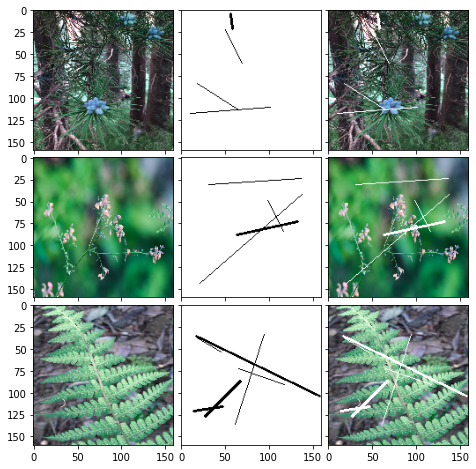

In [28]:
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3,3),
                 axes_pad=0.1
                 )

for idx, ax in enumerate(grid):
  if idx%3 == 0:
    ax.imshow(correct_images[idx//3])
  elif idx%3 == 1:
    ax.imshow(sample_masks[idx//3])
  else:
    ax.imshow(corrupted_images[idx//3])

plt.show()

In [29]:
class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Oblicz rozmiar wypełnienia, aby osiągnąć zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[0] - 1) / 2)),
            (int((self.kernel_size[0] - 1) / 2), int((self.kernel_size[0] - 1) / 2)),
        )

        # Rozmiar okna - używany do normalizacji
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        Będziemy używać metody Keras conv2d, i zasadniczo musimy
        pomnożenie maski przez dane wejściowe X, zanim zastosujemy
        konwolucji. Dla samej maski zastosujemy konwolucje z wszystkimi wagami
        ustawionymi na 1.
        Następnie przycinamy wartości maski do wartości pomiędzy 0 a 1
        '''

        # Należy dostarczyć zarówno obraz jak i maskę
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception(
                'PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Zastosuj konwolucje do maski
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Zastosuj konwolucje do obrazu
        img_output = K.conv2d(
            (images * masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Obliczanie współczynnika maski dla każdego piksela w masce wyjściowej
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Wyjście klipu ma być pomiędzy 0 a 1
        mask_output = K.clip(mask_output, 0, 1)

        # Usuń wartości współczynników, w których występują otwory
        mask_ratio = mask_ratio * mask_output

        # Normalizacja obrazu wyjściowego
        img_output = img_output * mask_ratio

        # Zastosuj bias tylko do obrazu (jeśli został wybrany)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Zastosuj aktywacje na obrazie
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Określa długość wyjściową konwolucji dla danej długości wejściowej.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

In [ ]:
def __encoder_layer(filters, in_layer, in_mask):
 conv1, mask1 = PConv2D(160, (3,3), strides=1, padding='same')([in_layer, in_mask])
 conv1 = keras.activations.relu(conv1)

 conv2, mask2 = PConv2D(160, (3,3), strides=2, padding='same')([conv1, mask1])
 conv2 = keras.layers.BatchNormalization()(conv2, training=True)
 conv2 = keras.activations.relu(conv2)

 return conv1, mask1, conv2, mask2

In [ ]:
def __decoder_layer( filter1, filter2, in_img, in_mask, share_img, share_mask):
 up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
 up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
 concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
 concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

 conv1, mask1 = PConv2D(filter1, (3,3), padding='same')([concat_img, concat_mask])
 conv1 = keras.activations.relu(conv1)

 conv2, mask2 = PConv2D(filter2, (3,3), padding='same')([conv1, mask1])
 conv2 = keras.layers.BatchNormalization()(conv2)
 conv2 = keras.activations.relu(conv2)

 return conv1, mask1, conv2, mask2

In [ ]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
def prepare_model(hp):
    input_size = (160, 160, 3)
    input_image = keras.layers.Input(input_size, name="input_1")
    input_mask = keras.layers.Input(input_size, name="input_2")

    n_filters = hp.Int('n_filters', min_value=32, max_value=256, step=32)
    n_decoders = hp.Int('n_decoders', min_value=50, max_value=450, step=30)

    conv1, mask1, conv2, mask2 = __encoder_layer(n_filters, input_image, input_mask)
    conv3, mask3, conv4, mask4 = __encoder_layer(2 * n_filters, conv2, mask2)
    conv5, mask5, conv6, mask6 = __encoder_layer(4 * n_filters, conv4, mask4)
    conv7, mask7, conv8, mask8 = __encoder_layer(8 * n_filters, conv6, mask6)

    conv9, mask9, conv10, mask10 = __decoder_layer(8 * n_filters, 4 * n_decoders, conv8, mask8, conv7, mask7)
    conv11, mask11, conv12, mask12 = __decoder_layer(4 * n_filters, 2 * n_decoders, conv10, mask10, conv5, mask5)
    conv13, mask13, conv14, mask14 = __decoder_layer(2 * n_filters, n_decoders, conv12, mask12, conv3, mask3)
    conv15, mask15, conv16, mask16 = __decoder_layer(n_filters, 3, conv14, mask14, conv1, mask1)

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    model = keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=dice_coef)

    return model

### Keras Tuner

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel=prepare_model,
    objective='val_loss',
    max_trials=3,
    seed=42,
    project_name=("projekt_kt")
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[early_stopping]
) 

Trial 3 Complete [00h 00m 25s]
val_loss: 0.4401436448097229

Best val_loss So Far: 0.43942010402679443
Total elapsed time: 00h 01m 17s


### Get the optimal hyperparameters

In [ ]:
tuner.results_summary()

Results summary
Results in ./projekt_kt
Showing 10 best trials
Trial summary
Hyperparameters:
n_filters: 128
n_decoders: 140
Score: 0.43942010402679443
Trial summary
Hyperparameters:
n_filters: 192
n_decoders: 50
Score: 0.43956258893013
Trial summary
Hyperparameters:
n_filters: 256
n_decoders: 170
Score: 0.4401436448097229


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
n_filters= best_hps.get('n_filters')
print(f'Number n_filters: {n_filters}')

Number n_filters: 128


In [ ]:
n_decoders = best_hps.get('n_decoders')
print(f'Number n_decoders: {n_filters}')

Number n_decoders: 128


#### ?

In [ ]:
model = prepare_model(best_hps)

In [ ]:
model.predict(train_ds)

In [ ]:
model.evaluate(train_ds)

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [ ]:
predictions = model.predict(val_ds)

In [ ]:
my_image = predictions[10]*255
image_resized = cv2.resize(my_image, (160,160))
cv2_imshow(image_resized)